In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataPath = "/content/drive/MyDrive/advanced ml/toxic/"

train = pd.read_csv(dataPath + 'train-2.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


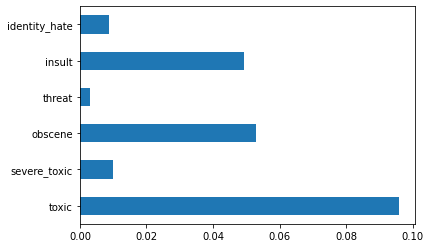

In [ ]:
train[types].mean().plot(kind='barh')

In [ ]:
train[types].sum(axis=1)==0

id
0000997932d777bf    True
000103f0d9cfb60f    True
000113f07ec002fd    True
0001b41b1c6bb37e    True
0001d958c54c6e35    True
                    ... 
ffe987279560d7ff    True
ffea4adeee384e90    True
ffee36eab5c267c9    True
fff125370e4aaaf3    True
fff46fc426af1f9a    True
Length: 159571, dtype: bool

In [ ]:
nb_clean = (train[types].sum(axis=1)==0).sum()

In [ ]:
nb_clean

143346

In [ ]:
print('clean:',nb_clean,'(',round(100*nb_clean/len(train),2),'% )')

clean: 143346 ( 89.83 % )


In [ ]:
test = pd.read_csv(dataPath + 'test.csv',index_col=0)
test_labels = pd.read_csv(dataPath + 'test_labels.csv',index_col=0)

In [ ]:
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
labelled_test = test.join(test_labels)

In [ ]:
disclosed = labelled_test.toxic>-1

In [ ]:
print(disclosed .mean(),'% of test is labelled')

0.41770912224804785 % of test is labelled


In [ ]:
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]

In [ ]:
print(train.shape,test.shape)

(223549, 7) (89186, 1)


In [ ]:
train.to_csv(dataPath+'tc_train.csv')
test.to_csv(dataPath+'tc_test.csv')

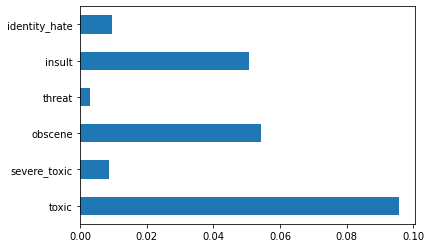

In [ ]:
train[types].mean().plot(kind='barh')

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle

Using function get_embeddings() from MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb create embeddings index - a dictionary with words as keys and embedding vectors as values.

In [ ]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            # remove white spaces and split
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index

In [ ]:
embeddings_index = get_embeddings(dataPath + 'crawl-300d-2M.vec')

Preprocess text with the function preprocess() from MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb. Text preprocessing before creating FastText embeddings includes: removing digits, isolating punctuation and replacing consecutive spaces with single one.

In [ ]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

Use preprocess() to preprocess comments and remove rare words. Create vocabulary of words that occur more than 5 times. To count occurrences use CountVectorizer which convers a collection of text documents to a matrix of token counts.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

train['comment_text'] = train.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train.comment_text)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
45259 top words


Check the first 10 words in the vocabulary top_words. Also check that added word "unknown" belongs to top_words

In [ ]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['orphanbot', 'etc', 'pows', 'contraversy', 'joof', "'semi", 'computed', 'tryign', 'libel', 'recalling']

Is "unknown" in top_words? 
 True


Replace all words in reviews['description'] that do not belong to the intersection of top_words and embeddings_index.keys() with UNKNOWN_PROXY. Create function filter_unknown(text, vocabulary, proxy) which does that.

In [ ]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [ ]:
train['comment_text'] = train.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

Prepare input data for neural network as shown in MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb. Preparation includes the following actions: Transform each text to sequence of integer numbers replacing each word with its vocabulary index. Make all vectors same length, truncating sequences longer than defined length and padding shorter ones.

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

Tokenize reviews by Keras preprocessing classes

Tokenizer: Class allowing to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

fit_on_texts(): Method of Tokenizer that updates internal vocabulary based on a list of texts. Required before using texts_to_sequences() or texts_to_matrix()

In [ ]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train.comment_text)
print(tokenizer)

Result of fit_on_texts() is word_index - list of tuples with words and their index values.

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

40185


[('unknown', 1),
 ('the', 2),
 ('to', 3),
 ('of', 4),
 ('and', 5),
 ('a', 6),
 ('you', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10),
 ('in', 11),
 ('it', 12),
 ('for', 13),
 ('this', 14),
 ('not', 15),
 ('on', 16)]

Method texts_to_sequences() turns each text into a sequence of integers. Integers are index values in word_index: check the first review, it starts with "aroma". That word is #16 in word_index. The first integer in the first list of seq is 16.

Method pad_sequences() pads sequences to the same lengths.

Dump data into file toxic_comment.pkl.

In [ ]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train.comment_text)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'toxic_comment.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[668, 77, 2, 133, 130, 176, 31, 658, 4322, 10972, 1109, 85, 347, 1, 52, 1, 12090, 1, 51, 6172, 16, 60, 2522, 147, 8, 2744, 34, 116, 1179, 15205, 2412, 1, 5, 48, 61, 245, 2, 357, 32, 2, 42, 28, 142, 1, 3422, 89, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 53, 2714, 14, 463, 3572, 1, 4414, 2647, 22, 1, 93, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 953, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195, 1]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  668    77     2   133   130   176    31   658  4322 10972  1109    85
   347     1    52     1 12090     1    51  6172    16    60  2522   147
     8  2744    34   116  1179 15205  2412     1     5    48    61   245
     2   357    32     2    42    28   142     1  3422    89     1     1
     1     1]


Step 8
Create neural network based on DistilBert model as shown in MScA_32017_AMLAI_TC6_Wine_Reviews_Bert.ipynb, tune it on train set and make submission. Take a weighted average of this submission and the one obtained on the step 7 to get better score.

in function get_embedding_matrix() below the following combination of iterator iter() and method next() allow sequentially moving through iterable object as in this simple example:

In [ ]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


Below iterator is used to find length of the first row of values of embeddings_index:

In [ ]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

Note that this is necessary because values of a dictionary have no attribute shape, so embeddings_index.values().shape will not work.

The following function get_embedding_matrix() makes embedding matrix from word_index and embeddings_index obtained above.

Embedding matrix shape is (len(word_index) + 1,embeddings_dim).

Row number 
i
 of the embedding matrix contains embedding vector of the word whith index in word_index equal to 
i
.

In [ ]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

Now preparation of the data is finished. It is possible to start building model.But it is common and convenient to create embedding layer and save it beforehand. This helpes separating data preparation and network fitting. Then only two files are necessary to run the network: wine_data.pkl and the embedding layer, both saved earlier.

In text processing networks embedding layer comes first after the input layer. It transforms sequences of integers (word indices) to sequences of correspondent embedding vectors using embedding matrix.

The function below creates and saves embedding layer. Setting trainable=False means that the weights of this layer (actually the elements of embedding matrix) will not be changed during model training.

In [ ]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = dataPath + 'toxic_comment_layer1.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


Model
The following architecture of the model was used in the competition by several participans.

In [ ]:
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model


def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(10, return_sequences=True)(x)
    x = Conv1D(5, kernel_size=2, padding="valid")(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(6, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=Adam())
    return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)
#with open(dataPath + 'toxic_comment.pkl', 'rb') as f: data = pickle.load(f) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, train.iloc[:,1:], 
                    test_size=0.2, random_state=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           12055800  
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50, 10)            12440     
                                                                 
 conv1d (Conv1D)             (None, 49, 5)             105       
                                                                 
 flatten (Flatten)           (None, 245)               0         
                                                             

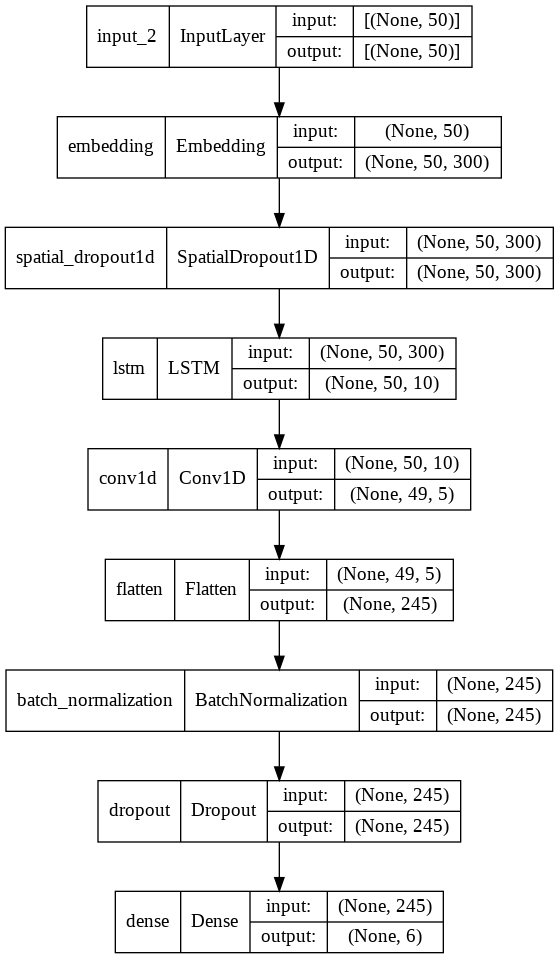

In [ ]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
plot_model(model, to_file='toxic_comment.png',show_shapes=True,show_layer_names=True)

In [ ]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=28, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Epoch 1/28
350/350 - 54s - loss: 0.2475 - val_loss: 0.0705 - 54s/epoch - 154ms/step
Epoch 2/28
350/350 - 49s - loss: 0.0760 - val_loss: 0.0634 - 49s/epoch - 140ms/step
Epoch 3/28
350/350 - 49s - loss: 0.0695 - val_loss: 0.0622 - 49s/epoch - 141ms/step
Epoch 4/28
350/350 - 49s - loss: 0.0677 - val_loss: 0.0607 - 49s/epoch - 140ms/step
Epoch 5/28
350/350 - 51s - loss: 0.0655 - val_loss: 0.0593 - 51s/epoch - 145ms/step
Epoch 6/28
350/350 - 57s - loss: 0.0647 - val_loss: 0.0584 - 57s/epoch - 161ms/step
Epoch 7/28
350/350 - 51s - loss: 0.0636 - val_loss: 0.0588 - 51s/epoch - 144ms/step
Epoch 8/28
350/350 - 51s - loss: 0.0628 - val_loss: 0.0587 - 51s/epoch - 145ms/step
validation AUC 0.31548502754553337


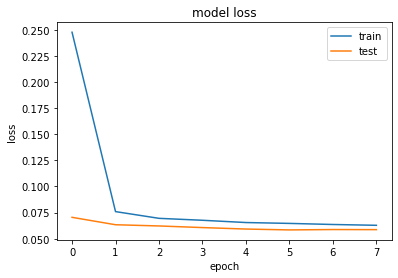

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
tctest = pd.read_csv(dataPath + 'tc_test.csv',index_col=0)
tctest.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

tctest['comment_text'] = tctest.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(tctest.comment_text)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
25113 top words


In [ ]:
tctest['comment_text'] = tctest.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [ ]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(tctest.comment_text)
print(tokenizer)

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

24011


[('unknown', 1),
 ('the', 2),
 ('to', 3),
 ('a', 4),
 ('and', 5),
 ('of', 6),
 ('you', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10),
 ('in', 11),
 ('it', 12),
 ('this', 13),
 ('for', 14),
 ('not', 15),
 ('on', 16)]

In [ ]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(tctest.comment_text)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'tctest_toxic_comment.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[1388, 205, 2845, 770, 9, 57, 20928, 82, 837, 292, 17, 3098, 66, 22, 7, 5, 5308, 7, 1542, 1, 1, 1, 8, 56, 205, 5150, 966, 1, 490, 4552, 5, 87, 7, 3, 2448, 31, 229, 7, 653, 20929, 42, 1, 2845, 770, 9, 38, 4082, 11, 674, 616, 322, 1, 424, 10992, 10, 126, 16, 157, 1, 5, 12685, 9, 249, 17106, 44, 1655, 51, 26, 4, 1964, 151, 1, 1, 1845, 490, 1897, 87, 218, 145, 502, 84, 1, 1], [1, 1, 1, 34, 1054, 1, 1, 1, 1, 1, 1, 2, 347, 9, 646, 18, 12, 9, 1, 2629, 1]]

Shape of `data`:  (89186, 50)

First prepared text in `data`: [ 1388   205  2845   770     9    57 20928    82   837   292    17  3098
    66    22     7     5  5308     7  1542     1     1     1     8    56
   205  5150   966     1   490  4552     5    87     7     3  2448    31
   229     7   653 20929    42     1  2845   770     9    38  4082    11
   674   616]


In [ ]:
data

NameError: ignored

In [ ]:
tctest_pred = model.predict(data, batch_size=BATCH_SIZE, verbose=0)

NameError: ignored

In [ ]:
result_df = pd.DataFrame(tctest_pred)
result_df.to_csv(dataPath + 'result.csv')

In [ ]:
pd.DataFrame(tctest_pred)

,0,1,2,3,4,5
0,0.753555,0.001956,0.160401,0.000740,0.081537,0.001811
1,0.585804,0.012428,0.131304,0.021844,0.188518,0.060102
2,0.589243,0.013746,0.140619,0.016517,0.183984,0.055891
3,0.607414,0.011925,0.134458,0.019985,0.178202,0.048016
4,0.607383,0.011760,0.100253,0.032346,0.177406,0.070851
...,...,...,...,...,...,...
89181,0.535575,0.015282,0.113919,0.035088,0.199266,0.100870
89182,0.600520,0.010483,0.142182,0.012655,0.198235,0.035925
89183,0.600075,0.010533,0.151377,0.013890,0.180689,0.043437
89184,0.530744,0.015813,0.166297,0.018284,0.213680,0.055183


In [ ]:
tctest

,comment_text
id,
00001cee341fdb12,yo bitch ja rule is more succesful then you'll...
0000247867823ef7,unknown unknown unknown from rfc unknown unkno...
00013b17ad220c46,unknown unknown unknown unknown unknown unknow...
00017563c3f7919a,unknown if you have a look back at the source ...
00017695ad8997eb,i don't anonymously edit articles at all unknown
...,...
fffcd0960ee309b5,unknown unknown unknown unknown i totally agre...
fffd7a9a6eb32c16,unknown unknown unknown throw from out field t...
fffda9e8d6fafa9e,unknown unknown unknown unknown unknown unknow...
